In [133]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

import model

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [77]:
returns = model.get_returns_forecast()

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


In [452]:
def bs_price(right, S, K, T, sigma, r):
    """
    Return's option price via Black-Scholes

    right: "P" or "C"
    S: Underlying price
    K: Strike price
    T: time to expiration (in fractions of a year)
    sigma: volatility of the underlying
    r: interest rate (in annual terms)
    """
    d1 = (1 / (sigma * np.sqrt(T))) * (np.log(S / K) + (r + sigma ** 2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)

    if right == "C":
        price = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * T)
        return price

    if right == "P":
        price = norm.cdf(-d2) * K * np.exp(-r * T) - norm.cdf(-d1) * S
        return price


def log_wealth_optim(f, pnl):
    """
    Returns the negative of log wealth for optimization
    """
    return -np.mean(np.log(1 + f * pnl))

class ShortIronCondor:
    def __init__(self, chain, dte, risk_free_rate):
        """
        Class for all information required to determine what option position to enter into
        and the kelly sizing percentage

        chain: pandas dataframe containing options chain
        vols: sample of future WEEKLY volatilities
        dte: days to expiration of options contracts given in chain
        risk_free_rate: current market risk free rate of return given in annualized terms
        """
        self.chain = chain
        self.underlying_price = self.chain.iloc[0]["underprice"]
        self.dte = dte
        self.risk_free_rate = risk_free_rate

        self.calc_values()
        (
            self.short_put,
            self.short_call,
            self.long_put,
            self.long_call,
        ) = self.find_contracts()
        self.premium = (self.short_call["mid_price"] + self.short_put["mid_price"]) - (
            self.long_put["mid_price"] + self.long_call["mid_price"]
        )
        # Deflate the premium by 10% to be conservative and account for slippage
        self.premium = 0.90 * self.premium
        self.max_loss = self.short_put["strike"] - self.long_put["strike"] - self.premium

    def calc_values(self):
        """
        Calculates Mid price and skew premium for each option in chain
        """
        atm_contract_index = (
            np.abs(self.chain["strike"] - self.underlying_price)
        ).idxmin()
        atm_impliedvol = self.chain.iloc[atm_contract_index]["impvol"]

        # Calculate option value for all options using ATM volatility
        self.chain["model_value"] = self.chain.apply(
            lambda x: bs_price(
                x["right"],
                x["underprice"],
                x["strike"],
                self.dte / 252,
                atm_impliedvol,
                self.risk_free_rate,
            ),
            axis=1,
        )
        self.chain["mid_price"] = (self.chain["bid"] + self.chain["ask"]) / 2
        self.chain["skew_premium"] = self.chain["mid_price"] - self.chain["model_value"]

    def find_contracts(self):
        """
        Finds put contract with highest skew premium, then call contract with closest delta.
        Then picks hedging contracts on either side so that required margin equals $1000
        Essentially, picks contracts for short Iron Condor position.
        """
        # Select a put to short that is OTM
        short_put = self.chain[
            (self.chain["right"] == "P")
            & (self.chain["strike"] < self.underlying_price)
        ]["skew_premium"].idxmax()
        short_put = self.chain.iloc[short_put]
        # Buy put option so our margin required is $1000
        long_put = self.chain[
            (self.chain["strike"] == (short_put["strike"] - 10))
            & (self.chain["right"] == "P")
        ].squeeze()

        # Find the corresponding call option to make the position delta neutral
        put_contract_delta = short_put["delta"]
        short_call = np.abs(
            self.chain[self.chain["right"] == "C"]["delta"] + put_contract_delta
        ).idxmin()
        short_call = self.chain[self.chain["right"] == "C"].iloc[short_call]
        # Find respective call hedge option
        long_call = self.chain[
            (self.chain["strike"] == (short_call["strike"] + 10))
            & (self.chain["right"] == "C")
        ].squeeze()

        return short_put, short_call, long_put, long_call
    
    def pnl(self, underlying_price):
        """
        Calculates profit and loss of position at expiration given the underlying price.
        """
        # If underlying is between short strikes
        if self.short_call["strike"] >= underlying_price >= self.short_put["strike"]:
            pnl = self.premium
        # If underlying is under the short put
        elif underlying_price < self.short_put["strike"]:
            pnl = max(
                (underlying_price - self.short_put["strike"]) + self.premium, -self.max_loss
            )
        # If underlying is above short call
        elif underlying_price > self.short_call["strike"]:
            pnl = max(
                (self.short_call["strike"] - underlying_price) + self.premium, -self.max_loss
            )

        return pnl

In [453]:
chain = pd.read_csv("option_chain.csv")
position = ShortIronCondor(chain, 5, .01)

In [461]:
prices = position.underlying_price * (1 + (returns * 0.50))
pnl_func = np.vectorize(position.pnl)
pnls = pnl_func(prices) * 100
rets = pnls / 1000

initial = 1
result = minimize(
    log_wealth_optim,
    x0=initial,
    args=(rets),
    constraints=(
        {"type": "ineq", "fun": lambda x: x},
        {"type": "ineq", "fun": lambda x: 1 - x},
    )
)

In [462]:
allocs = np.linspace(0, 1, 1000)
test = [np.mean(np.log(1 + f * rets)) for f in allocs]

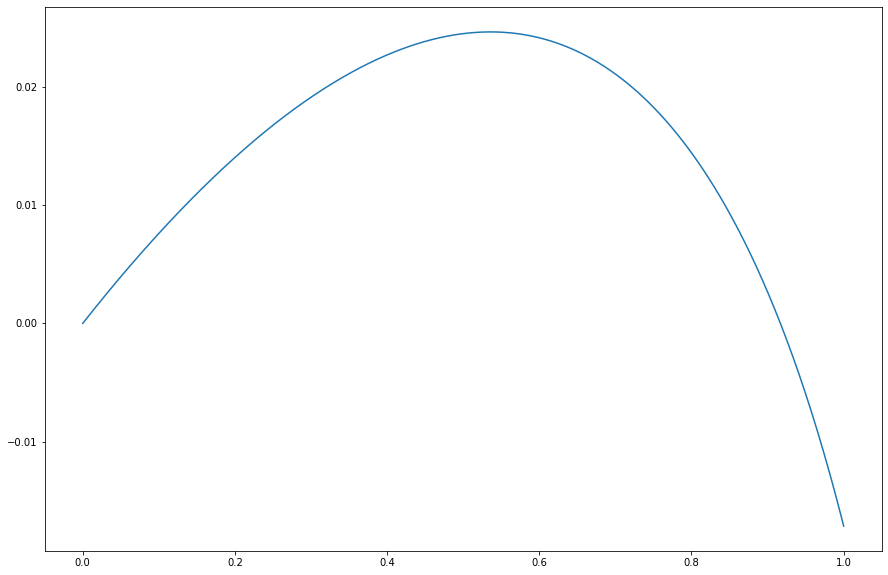

In [463]:
plt.plot(allocs, test)